# WELCOME!!!!

## In this mini project, we will take a look at how to create a custom data loader, build a CNN from scratch and then evaluate our model, all in PyTorch !!!

# PART 1: Data acquisition and EDA

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
%matplotlib inline

In [ ]:
test_path = '../input/histopathologic-cancer-detection/test'
train_path = '../input/histopathologic-cancer-detection/train'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [ ]:
train_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

In [ ]:
train_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

## As we can see, we have some inbalance in our dataset, but nothing to worry about.

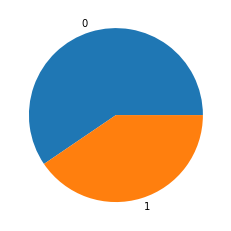

In [ ]:
plt.pie(train_labels['label'].value_counts(), labels=[0,1])
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

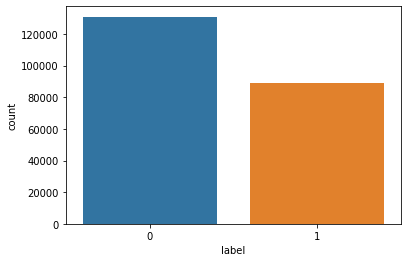

In [ ]:
sns.countplot(train_labels['label'])

## We can select only the label we want by slicing the 'label' column.

In [ ]:
cancerous_img = train_labels.loc[train_labels['label']==1]
healthy_img = train_labels.loc[train_labels['label']==0]

In [ ]:
cancerous_img.head()

id  label
1   c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
6   a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7   7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
11  c3d660212bf2a11c994e0eadff13770a9927b731      1
14  94fa32b29cc1c00403176c0795fffa3cfaa0f20e      1

In [ ]:
healthy_img.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0

## Let's plot some images. We will try to see with the naked eye what the differences are between a tumor and a healthy cell

<Figure size 1440x720 with 0 Axes>

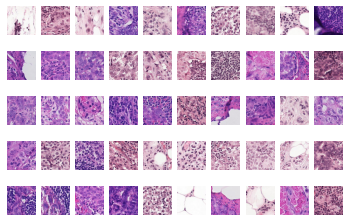

In [ ]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(5, 10)
for i, j in enumerate(cancerous_img['id'][:50]):
    img_path = os.path.join(train_path,j+'.tif')
    img = Image.open(img_path)
    plt.subplot(5,10,i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

<Figure size 1440x720 with 0 Axes>

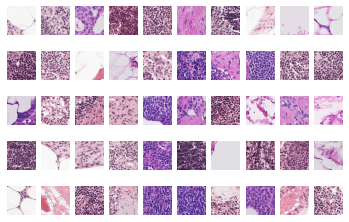

In [ ]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(5, 10)
for i, j in enumerate(healthy_img['id'][:50]):
    img_path = os.path.join(train_path,j+'.tif')
    img = Image.open(img_path)
    plt.subplot(5,10,i+1)
    plt.imshow(np.array(img))
    plt.axis('off')

In [ ]:
labels = train_labels['label']

# PART 2: CREATE A CUSTOM DATA LOADER

## For this competition, we are going to need to create our custom dataloader, otherwise PyTorch will throw an error with the built-in version. We are going to put two options: transforms, which will indicate which transformations we want to perform (if any), and whether we want to show the picture or not.       
## We are also going to create a custom method to get the list of the transforms of the dataset, in case we forget what we did.

In [ ]:
class CustomDataLoader():
    def __init__(self, labels, dir_path, transforms=None, show=False):
        self.labels = labels
        self.dir_path = dir_path
        self.transform = transforms
        self.show=show
        
    def __len__(self):
        return len(self.labels)
    
    def __gettransforms__(self):
        return self.transform
    
    def __getshow__(self):
        return self.show
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.dir_path, self.labels.iloc[idx,0] +'.tif')
        image = Image.open(img_path)
        label = self.labels.iloc[idx,1]
        
        if self.transform:
            image = self.transform(image)
            if self.show == True:
                plt.imshow(image.permute(1,2,0))
        else:
            if self.show == True:
                plt.imshow(image)
        return image, label
        

## We create some transforms, just to see what the end results look like

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.Grayscale(),
    transforms.GaussianBlur((7,13)),
    transforms.ToTensor()])

## We create two datasets, one with the transforms and one without, just to see what the transforms look like with our pictures. We will create the real dataset further down the line.

In [ ]:
data = CustomDataLoader(train_labels, train_path, show=True)
data_transform = CustomDataLoader(train_labels, train_path, transforms=transform, show=True)

In [ ]:
print(data.__gettransforms__(), data_transform.__gettransforms__())

None Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
    Grayscale(num_output_channels=1)
    GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 2.0))
    ToTensor()
)


## Plot some random transformed and non-transformed images

In [ ]:
random_idx = [np.random.randint(1,data.__len__()) for _ in range(10)]
print(random_idx)

[166658, 71628, 4433, 116909, 86125, 79162, 58442, 125808, 152196, 4387]


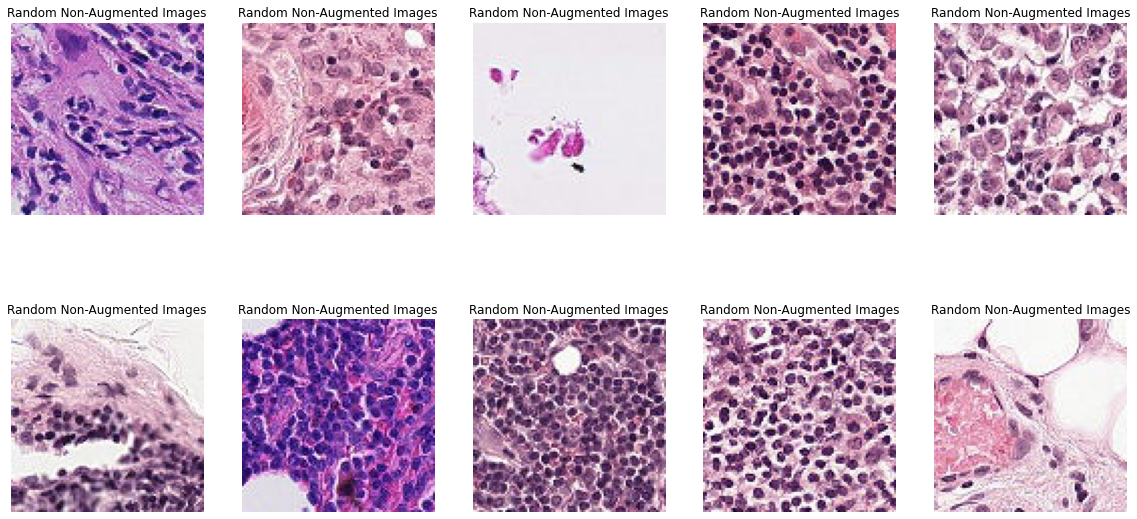

In [ ]:
plt.figure(figsize=(20,10))
for i,j in enumerate(random_idx):
    plt.subplot(2,5,i+1)
    data.__getitem__(j)
    plt.title('Random Non-Augmented Images')
    plt.axis('off')
plt.show()

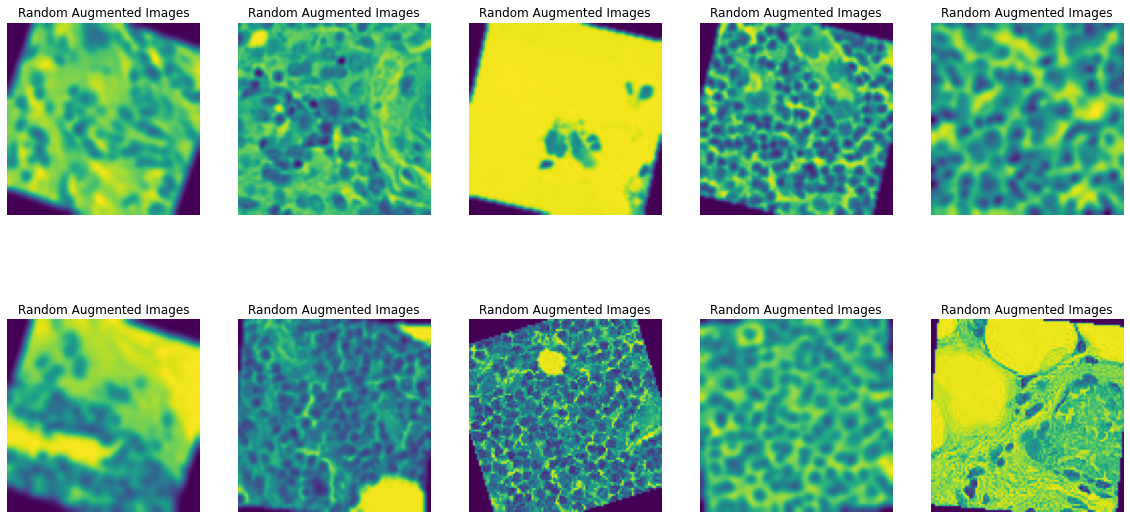

In [ ]:
plt.figure(figsize=(20,10))
for i,j in enumerate(random_idx):
    plt.subplot(2,5,i+1)
    data_transform.__getitem__(j)
    plt.title('Random Augmented Images')
    plt.axis('off')
plt.show()

## PART 3: BUILDING THE ACTUAL DATASET

In [ ]:
data =  CustomDataLoader(train_labels, train_path)

In [ ]:
training_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

## To increase the training and inference speed, we only take 10000 pictures. This won't impact the final model too much, as we have good quality data.

In [ ]:
train_labels = train_labels[:10000]
train_labels.label.value_counts()

0    6020
1    3980
Name: label, dtype: int64

## Next, we do a 80/20 train test split to train our model on.

In [ ]:
train, val = train_test_split(train_labels, stratify=train_labels.label, test_size=0.2)

In [ ]:
train_data = CustomDataLoader(train, train_path, training_transforms, show=True)
val_data = CustomDataLoader(val, train_path, transforms.Compose([transforms.ToTensor(),
                                                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]),
                           show=True)

In [ ]:
train_data.__len__(), val_data.__len__()

(8000, 2000)

## Here are some of the images inside our datasets:

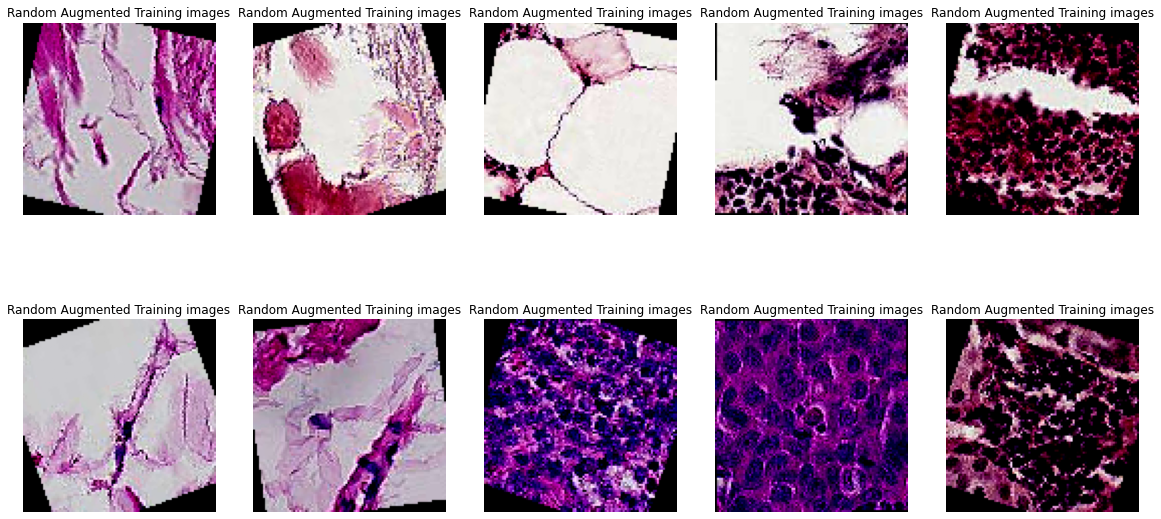

In [ ]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    train_data.__getitem__(i)
    plt.title('Random Augmented Training images')
    plt.axis('off')
plt.show()

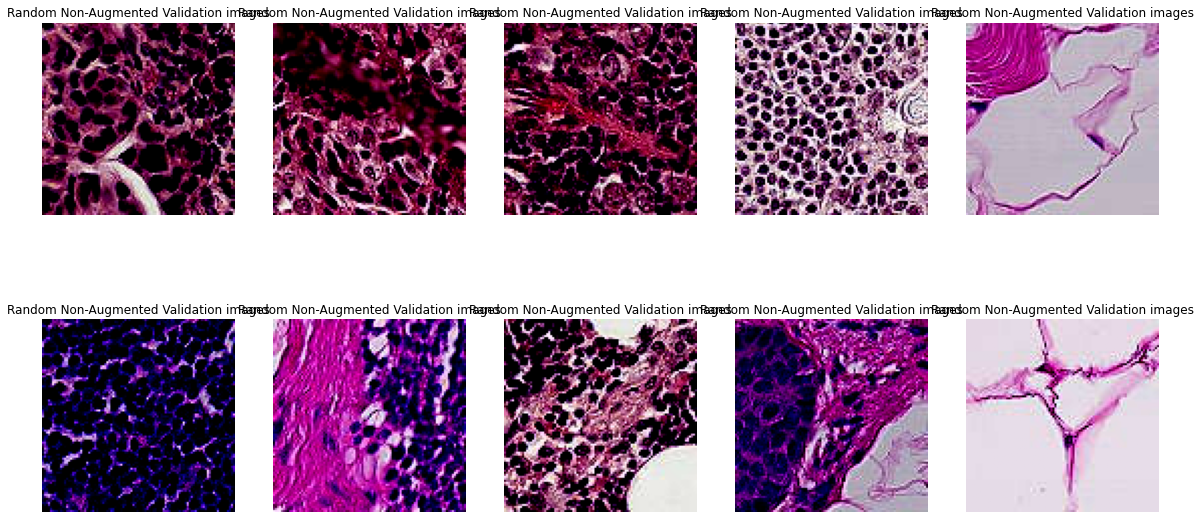

In [ ]:
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    val_data.__getitem__(i)
    plt.title('Random Non-Augmented Validation images')
    plt.axis('off')
plt.show()

In [ ]:
train_data.show=False
val_data.show=False

In [ ]:
train_loader = DataLoader(train_data, batch_size=256)
val_loader = DataLoader(val_data, batch_size=256)

## PART 4: BUILDING THE MODEL

### Architecture: I've tried two architectures: the first one (the actual model we will be using) will use two 2D convolution layers, which doubles the number of channels at each step. Then we have a maxpooling layer to reduce the size of the image. We again have two 2D convolution layers, which ends with 48 output channels. Finally, the last layer is a fully connected layer that we will use to make our predictions. The final size of the image is 48 * 24 * 24. We end with a sigmoid activation function layer because we need to have a binary label [0,1] to make our predictions

In [ ]:
class CNN_1(nn.Module):
    def __init__(self, num_classes = 2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=(1,1), padding=(1,1))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=(1,1), padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # Half the dimension size
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=(1,1), padding=(1,1))
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=(1,1), padding=(1,1))
        self.fc = nn.Linear(48*24*24, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 48*24*24)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [ ]:
#class CNN_2(nn.Module):
#    def __init__(self, num_classes = 2):
#        super().__init__()
#        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=(1,1), padding=(1,1))
#        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=(1,1), padding=(1,1))
#        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # Half the dimension size
#        self.fc = nn.Linear(12*48*48, num_classes)
#        
#    def forward(self,x):
#        x = F.relu(self.conv1(x))
#        x = F.relu(self.conv2(x))        
#        x = self.pool(x)
#        x = x.view(-1, 12*48*48)
#        x = self.fc(x)
#        return x

### For the Loss function, we use CrossEntropy. We could have used the negative log likelihood loss as well, however for our case the CrossEntropy had better results. Furthermore, we use Adam as the optimizer since it's the fastest and most reliable. At each step of the training, we will be manually computing the training loss and accuracy so that we can plot it (we could have used tensorboard but Kaggle doesn't support it)

In [ ]:
model_1 = CNN_1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model_1.parameters(), lr=0.001)

In [ ]:
train_loss_model_1 = []
train_acc_model_1 = []
correct_model_1 = 0
total_model_1 = 0
steps = len(train_loader)

for epoch in range(5):
    current_loss_model_1 = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model_1(images)
        loss = criterion(outputs, labels)
        
        # Backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        current_loss_model_1 += loss.item()
        _, pred = outputs.max(1)
        total_model_1 += labels.shape[0]
        correct_model_1 += pred.eq(labels).sum().item()
        
        if (i+1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{5}, Step: {i+1}/{steps}, Loss: {loss.item()}')
    
    acc = 100.0 * correct_model_1/total_model_1
    train_loss_model_1.append(current_loss_model_1/steps)
    train_acc_model_1.append(acc)
    print(f'The accuracy for the epoch {epoch+1} is : {acc}')

print('END')

Epoch: 1/5, Step: 10/32, Loss: 0.6640793681144714
Epoch: 1/5, Step: 20/32, Loss: 0.6371843814849854
Epoch: 1/5, Step: 30/32, Loss: 0.617544412612915
The accuracy for the epoch 1 is : 61.9875
Epoch: 2/5, Step: 10/32, Loss: 0.5661754608154297
Epoch: 2/5, Step: 20/32, Loss: 0.5314818024635315
Epoch: 2/5, Step: 30/32, Loss: 0.534439206123352
The accuracy for the epoch 2 is : 69.01875
Epoch: 3/5, Step: 10/32, Loss: 0.5246065855026245
Epoch: 3/5, Step: 20/32, Loss: 0.5124767422676086
Epoch: 3/5, Step: 30/32, Loss: 0.5263537764549255
The accuracy for the epoch 3 is : 71.8625
Epoch: 4/5, Step: 10/32, Loss: 0.5208528637886047
Epoch: 4/5, Step: 20/32, Loss: 0.5111170411109924
Epoch: 4/5, Step: 30/32, Loss: 0.5250177383422852
The accuracy for the epoch 4 is : 73.365625
Epoch: 5/5, Step: 10/32, Loss: 0.5187190771102905
Epoch: 5/5, Step: 20/32, Loss: 0.5108765363693237
Epoch: 5/5, Step: 30/32, Loss: 0.5214866995811462
The accuracy for the epoch 5 is : 74.2825
END


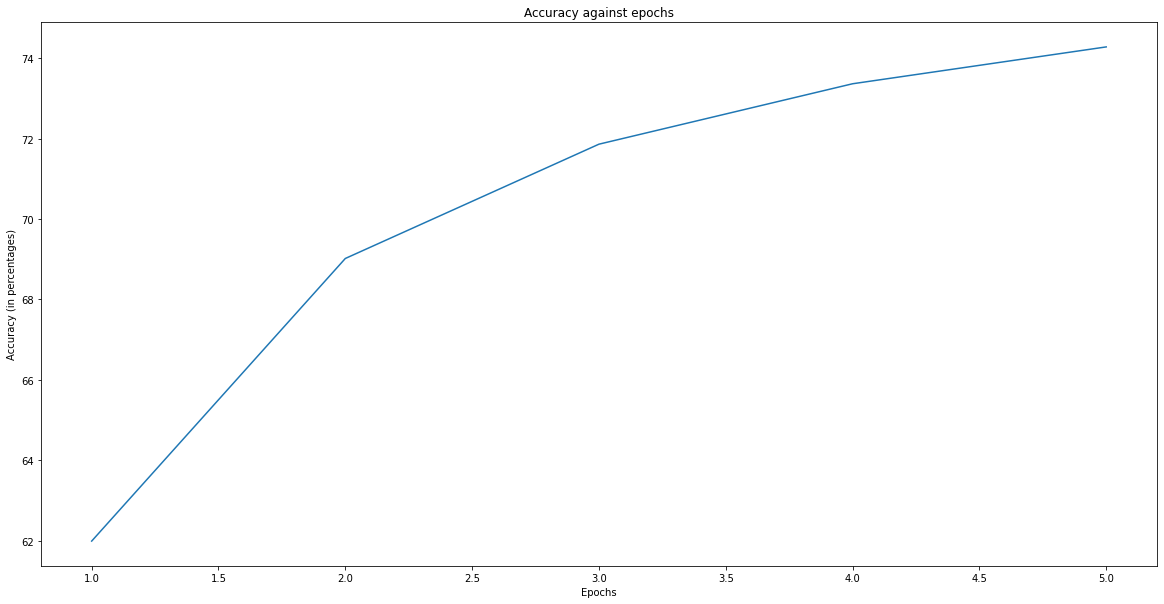

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([1,2,3,4,5], train_acc_model_1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (in percentages)')
plt.title('Accuracy against epochs')
plt.show()

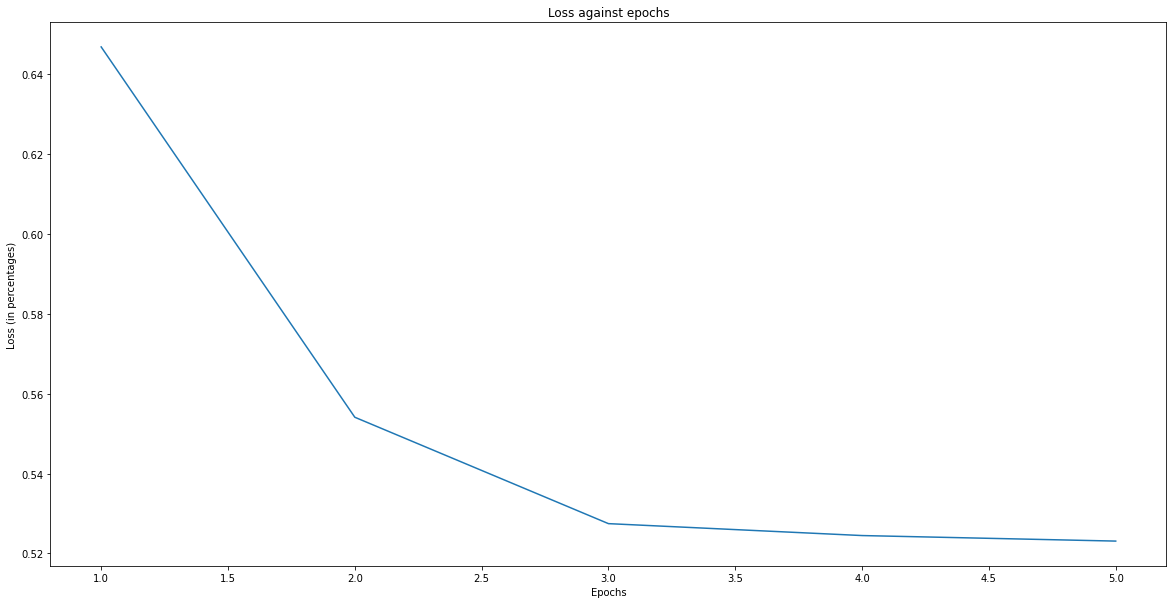

In [ ]:
plt.figure(figsize=(20,10))
plt.plot([1,2,3,4,5], train_loss_model_1)
plt.xlabel('Epochs')
plt.ylabel('Loss (in percentages)')
plt.title('Loss against epochs')
plt.show()

## Check accuracy on the validation dataset

In [ ]:
with torch.no_grad():
    total, correct = 0,0
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        out = model_1(images)
        _, preds = out.max(1)
        total += labels.shape[0]
        correct += (preds==labels).sum().item()
    print(f'The accuracy on the validation set is: {100*correct/total}%')

The accuracy on the validation set is: 76.05%


## FINAL PART: MAKING THE PREDICTIONS

In [ ]:
test_data = CustomDataLoader(sample_submission, test_path, 
                             transforms=transforms.Compose([transforms.ToTensor(),
                                                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))

In [ ]:
test_loader=DataLoader(test_data, 
                       batch_size=256)

In [ ]:
model_1.eval()

predictions = []

for i, (images, labels) in enumerate(test_loader):
    images, labels = images.to(device), labels.to(device)
    out = model_1(images)
    
    preds = out[:,1].detach().cpu().numpy()
    for i in preds:
        predictions.append(i)


In [ ]:
print(predictions[:5])

[0.0008214163, 0.8608847, 2.6002265e-08, 0.0038697585, 0.0017678054]


In [ ]:
sample_submission['label'] = predictions
sample_submission.head()
sample_submission.to_csv('submission.csv', index=False)

# CONCLUSION

## From this mini project, we've seen how to read, clean and perform some transforms on images with PyTorch. We've also created a CNN from scratch, and scored a very respectable 83% on the leaderboard of Kaggle. 

## For future iterations on this project, we could build a bigger CNN, or even do some transfer learning and see how pre-trained models fare (like Yolov6 for instance). We could also train the model on the entire data set.

# THANK YOU :D